### Libraries used training, testing and hyperparameterizing our self made neural network.

In [1]:
from FFNN import NeuralNetwork, train_network, train_network_momentum, train_network_stocastic_momentum, train_network_SRMSprop, train_network_stocastic_ADAM
import copy
import activation_functions as af
import cost_functions as cf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### Library used for selecting the right fontsize wrt revtex4 in LaTeX

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Widths in inches from revtex4's layout
# Single column ~3.375in, double column ~7in
columnwidth = 3.375  # use 7.0 for two-column-wide figures

# Compute figure size (width, height)
fig_width = columnwidth
fig_height = columnwidth / 1.618  # golden ratio for aesthetics
fig_size = [fig_width, fig_height]

mpl.rcParams.update({
    # Use LaTeX for text rendering
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": [],  # empty means use LaTeX default (Computer Modern)
    "font.size": 10.0,  # matches REVTeX's \normalsize

    # Adjust tick and label sizes
    "axes.labelsize": 10.0,
    "legend.fontsize": 8.0,
    "xtick.labelsize": 8.0,
    "ytick.labelsize": 8.0,

    # Figure dimensions
    "figure.figsize": fig_size,

    # Save with good resolution
    "savefig.dpi": 300,
})

### Generate data
Using the same function and seed for generating data as in project 1.

In [3]:
def generate_data(n, noise = True):
    # Fixed seed value to ensure consisten results across runs
    seed = 42
    np.random.seed(seed)
    # Creating an array with equally spaced data
    x = np.linspace(-1, 1, n)
    # Runges equation with noise
    if noise:
        y = 1 / (1 + 25*x**2) +  np.random.normal(0, 0.1, size=n)
    else:
        y = 1 / (1 + 25*x**2)
    return x, y

In [4]:
n = 50
x, y = generate_data(n)
x = x.reshape(-1,1)
y = y.reshape(-1,1)

### Visualizing the data we are working with

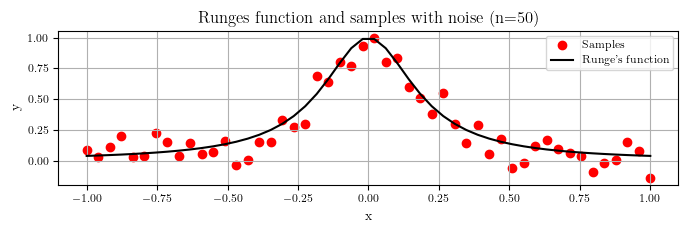

In [5]:
plt.figure(figsize=(8, 2))
plt.scatter(x, y, color='red', linewidth=1, label='Samples')
plt.plot(x, 1/(1+25*x**2), color = 'k', label = "Runge's function")
plt.title("Runges function and samples with noise (n=50)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

### Train, test split

In [6]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Scaling inputs

In [7]:
# Scale inputs
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test  = scaler.transform(X_test)

### Training two neural networks
1. One architecture with  1 hidden layer with 50 nodes.
2. One architecture with  2 hidden layers with 50 and 100 nodes respectively.

In [8]:
# Creating the neural networks
nn_1H50N = NeuralNetwork(
    network_input_size=x_train.shape[1],
    layer_output_sizes=[50, 1],
    activation_funcs=[af.sigmoid, af.identity],
    cost_func=cf.mse)

nn_2H50N100N = NeuralNetwork(
    network_input_size=x_train.shape[1],
    layer_output_sizes=[50, 100, 1],
    activation_funcs=[af.sigmoid, af.sigmoid, af.identity],
    cost_func=cf.mse)

# Training the neural network
train_network_stocastic_momentum(nn_1H50N, x_train, y_train, eta=0.01, epochs=100)
train_network_stocastic_momentum(nn_2H50N100N, x_train, y_train, eta=0.01, epochs=100)

# Predicting outputs
prediction_1 = nn_1H50N.predict(x_test)
prediction_2 = nn_2H50N100N.predict(x_test)

# Computing the MSE on unscaled data
mse_1layer = cf.mse(y_test, prediction_1)
mse_2layers = cf.mse(y_test, prediction_2)


print("1 Hidden layer with 50 nodes:\n=========================")
print(f"MSE: {mse_1layer:.5f}\n")

print("2 Hidden layers with 50 and 100 nodes:\n=========================")
print(f"MSE : {mse_2layers:.5f}")

1 Hidden layer with 50 nodes:
MSE: 0.06131

2 Hidden layers with 50 and 100 nodes:
MSE : 0.01461


## Hyperparameter tuning
### Tuning the optimizer algorithm and learning rate

In [9]:
# When hyperparameterizing we want to find the parameters that perform best over a given amount of runs, since stochastic gradient descent methods are volatile in nature.
def update_counter(counter, matrix, labels_y, labels_x):
    # Tracks the combination with the lowest MSE for each run and accumulates it.
    min_idx = np.unravel_index(np.nanargmin(matrix), matrix.shape)
    label_y = labels_y[min_idx[0]]
    label_x = labels_x[min_idx[1]]
    counter[(label_y, label_x)] += 1

In [10]:
# Parameters we are tuning 
optimizers = [train_network,                    # Gradient descent
              train_network_stocastic_momentum, # Stochastic gradient descent with momentum
              train_network_SRMSprop,           # RMSProp
              train_network_stocastic_ADAM]     # ADAM

optimizer_labels = ["GD", "SGD", "RMSprop", "ADAM"]
lr_labels = [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"]
learning_rates = np.logspace(-4, -1, num=4)
epochs = 100
runs = 100  # number of experiments

# Tracking
combination_counter = Counter()
avg_mse_matrix_op_lr = np.zeros((len(optimizers), len(learning_rates)))

for run in range(runs):
    # Printing progress
    if (run + 1) % 20 == 0 or (run + 1) == runs:
        print(f"Run {run + 1}/{runs}")

    # Initialize a base network for this run
    base_nn = NeuralNetwork(
        x.shape[1],
        [50, 100, 1],
        [af.sigmoid, af.sigmoid, af.identity],
        cf.mse)
    
    layers_init = copy.deepcopy(base_nn.layers)

    mse_matrix = []

    # Iterating through all combinations of optimizers and learning rates, and calculate the corresponding MSE.
    for optimizer in optimizers:
        mse_row = []
        for eta in learning_rates:
            nn = NeuralNetwork(
                x.shape[1],
                [50, 100, 1],
                [af.sigmoid, af.sigmoid, af.identity],
                cf.mse)

            # Using the same weights and biases across all models
            nn.layers = copy.deepcopy(layers_init)

            optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
            predictions = nn.predict(x_test)
            mse = cf.mse(y_test, predictions)
            mse_row.append(mse)

        mse_matrix.append(mse_row)

    mse_matrix = np.array(mse_matrix)

    # Accumulate MSEs across all runs
    avg_mse_matrix_op_lr += mse_matrix

    # Find the combination with the lowest MSE for this run
    update_counter(combination_counter, mse_matrix, optimizer_labels, [f"{lr:.4e}" for lr in learning_rates])

# Average MSE across all runs
avg_mse_matrix_op_lr /= runs

print("\nHow often each combination achieved the lowest MSE:")
for combo, count in combination_counter.most_common():
    print(f"{combo}: {count} times")

c:\Skole\Anvendt dataanalyse og Maskinlæring\FYS-STK3155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
c:\Skole\Anvendt dataanalyse og Maskinlæring\FYS-STK3155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: overflow encountered in square
  lambda ans, x, y: unbroadcast_f(y, lambda g: -g * x / y**2),
c:\Skole\Anvendt dataanalyse og Maskinlæring\FYS-STK3155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:160: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp, lambda ans, x: lambda g: ans * g)


Run 20/100
Run 40/100
Run 60/100
Run 80/100
Run 100/100

How often each combination achieved the lowest MSE:
('ADAM', '1.0000e-01'): 77 times
('ADAM', '1.0000e-02'): 17 times
('SGD', '1.0000e-02'): 6 times


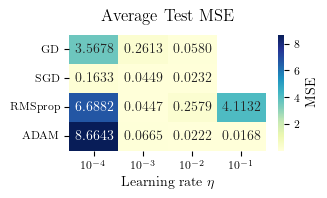

In [ ]:
# Plotting heatmap
plt.figure()
sns.heatmap(
    avg_mse_matrix_op_lr,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    xticklabels=lr_labels,
    yticklabels=optimizer_labels,
    cbar_kws={"label": "MSE"},)

plt.title(f"Average Test MSE", pad=10)
plt.xlabel(r"Learning rate $\eta$")
plt.tight_layout()
plt.show()


### Tuning the activation functions in the two hidden layerse

In [12]:
optimizer = train_network_stocastic_ADAM
eta = 1e-1
epochs = 100
runs = 100  # number of experiments

# Activation functions we are iterating over
activation_functions = [af.sigmoid, af.ReLU, af.leaky_ReLU]
activation_labels = ["Sigmoid", "ReLU", "Leaky ReLU"]
lr_labels = [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"]

# Tracking
combination_counter = Counter()
avg_mse_matrix_af = np.zeros((len(activation_functions), len(activation_functions)))

for run in range(runs):
    # Printing progress
    if (run + 1) % 20 == 0:
        print(f"Run {run + 1}/{runs}")

    # Initialize a new base for this run
    base_nn = NeuralNetwork(
        x.shape[1],
        [50, 100, 1],
        [af.sigmoid, af.sigmoid, af.identity],
        cf.mse)
    
    # Using the same weights and biases across all models
    layers_init = copy.deepcopy(base_nn.layers)

    mse_matrix = []

    # Iterating through all the different combinations of activations functions for two hidden layers, and calculate the corresponding MSE.
    for hidden1 in activation_functions:
        mse_row = []
        for hidden2 in activation_functions:
            nn = NeuralNetwork(
                x.shape[1],
                [50, 100, 1],
                [hidden1, hidden2, af.identity],
                cf.mse)
            # Using the same weights and biases across all models
            nn.layers = copy.deepcopy(layers_init)

            optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
            predictions = nn.predict(x_test)
            mse = cf.mse(y_test, predictions)
            mse_row.append(mse)
        mse_matrix.append(mse_row)

    mse_matrix = np.array(mse_matrix)
    
    # Accumulate MSEs across all runs
    avg_mse_matrix_af += mse_matrix  

    # Find the combination with the lowest MSE this run
    update_counter(combination_counter, mse_matrix, activation_labels, activation_labels)

# Average MSE across all runs
avg_mse_matrix_af /= runs

print("\nHow often each combination achieved the lowest MSE:")
for combo, count in combination_counter.most_common():
    print(f"{combo}: {count} times")


Run 20/100
Run 40/100
Run 60/100
Run 80/100
Run 100/100

How often each combination achieved the lowest MSE:
('Sigmoid', 'Sigmoid'): 70 times
('ReLU', 'Sigmoid'): 12 times
('Leaky ReLU', 'Sigmoid'): 11 times
('Leaky ReLU', 'Leaky ReLU'): 3 times
('Leaky ReLU', 'ReLU'): 1 times
('ReLU', 'ReLU'): 1 times
('Sigmoid', 'ReLU'): 1 times
('ReLU', 'Leaky ReLU'): 1 times


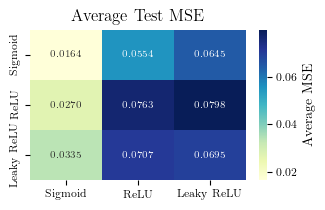

In [ ]:
# Heatmap
fig, ax = plt.subplots(figsize=(3.375, 2.2))  # width x height in inches
sns.heatmap(avg_mse_matrix_af, annot=True, fmt=".4f", cmap="YlGnBu",
            xticklabels=activation_labels,
            yticklabels=activation_labels,
            cbar_kws={"label": "Average MSE"},
            annot_kws={"size": 7}, ax=ax)

ax.set_title("Average Test MSE", pad=6)
plt.tight_layout()
plt.show()


### Tuning the numbers of hidden layers and number of nodes in each hidden layers

In [25]:
optimizer = train_network_stocastic_ADAM
activation_functions = [af.sigmoid, af.sigmoid, af.sigmoid, af.sigmoid, af.identity]  # supports up to 4 hidden layers
eta = 1e-1
epochs = 100
runs = 100

# Define number of layers and nodes to test
num_layers = [1, 2, 3, 4]
num_nodes = [20, 40, 60, 80, 100]

# Initialize matrix to store average MSEs
avg_mse_matrix_layers_nodes = np.zeros((len(num_layers), len(num_nodes)))

for run in range(runs):
    if (run + 1) % 10 == 0:
        print(f"Run {run + 1}/{runs}")
    
    for i, layers in enumerate(num_layers):
        mse_row = []
        for nodes in num_nodes:
            # Define the hidden layer configuration
            hidden_layers = [nodes] * layers  # same number of nodes in each hidden layer
            
            # Build network with correct activations
            activations = [af.sigmoid] * layers + [af.identity]

            nn = NeuralNetwork(
                x.shape[1],
                hidden_layers + [1],  # output layer
                activations,
                cf.mse
            )

            # Train and evaluate
            optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
            predictions = nn.predict(x_test)
            mse = cf.mse(y_test, predictions)
            mse_row.append(mse)
        
        # Store results
        avg_mse_matrix_layers_nodes[i, :] += mse_row

# Average across runs
avg_mse_matrix_layers_nodes /= runs

Run 10/100
Run 20/100
Run 30/100
Run 40/100
Run 50/100
Run 60/100
Run 70/100
Run 80/100
Run 90/100
Run 100/100


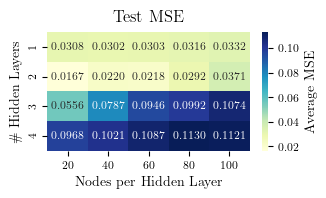

In [34]:
# Heatmap
plt.figure()
sns.heatmap(avg_mse_matrix_layers_nodes,
            annot=True,fmt=".4f",cmap="YlGnBu",
            xticklabels=num_nodes,yticklabels=num_layers,
            cbar_kws={"label": "Average MSE"}, annot_kws={"size": 8})

plt.title("Test MSE", pad=8)
plt.xlabel("Nodes per Hidden Layer")
plt.ylabel(r"\# Hidden Layers")
plt.tight_layout()
plt.show()


### Tuning the numbers of nodes in each of the two hidden layers

In [14]:
optimizer = train_network_stocastic_ADAM
activation_functions = [af.sigmoid, af.sigmoid, af.identity]
eta = 1e-1
epochs = 100
runs = 100  # number of experiments

# Number of nodes we are iterating over
num_nodes = [20, 40, 60, 80, 100]
labels =  ["20", "40", "60", "80", "100"]
# Tracking
combination_counter = Counter()
avg_mse_matrix_nodes = np.zeros((len(num_nodes), len(num_nodes)))

for run in range(runs):
    # Printing progress
    if (run + 1) % 20 == 0:
        print(f"Run {run + 1}/{runs}")

    mse_matrix = []

    # Iterating through different amount of nodes in the two hidden layers, and calculate the corresponding MSE
    for hidden1 in num_nodes:
        mse_row = []
        for hidden2 in num_nodes:
            nn = NeuralNetwork(
                x.shape[1],
                [hidden1, hidden2, 1],
                activation_functions,
                cf.mse)

            optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
            predictions = nn.predict(x_test)
            mse = cf.mse(y_test, predictions)
            mse_row.append(mse)
        mse_matrix.append(mse_row)

    mse_matrix = np.array(mse_matrix)
    
    # Accumulate MSEs across all runs
    avg_mse_matrix_nodes += mse_matrix  

    # Find the combination with the lowest MSE this run
    update_counter(combination_counter, mse_matrix, labels, labels)


# Average MSE across all runs
avg_mse_matrix_nodes  /= runs

print("\nHow often each combination achieved the lowest MSE:")
for combo, count in combination_counter.most_common():
    print(f"{combo}: {count} times")

Run 20/100
Run 40/100
Run 60/100
Run 80/100
Run 100/100

How often each combination achieved the lowest MSE:
('40', '100'): 18 times
('40', '80'): 15 times
('40', '60'): 14 times
('40', '40'): 13 times
('60', '100'): 8 times
('60', '60'): 7 times
('60', '80'): 6 times
('60', '20'): 3 times
('60', '40'): 3 times
('80', '80'): 3 times
('20', '20'): 2 times
('80', '100'): 2 times
('80', '60'): 1 times
('20', '100'): 1 times
('20', '60'): 1 times
('20', '40'): 1 times
('40', '20'): 1 times
('100', '100'): 1 times


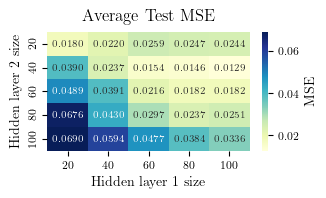

In [ ]:
# Heatmap
plt.figure()
sns.heatmap(avg_mse_matrix_nodes, annot=True, fmt=".4f", cmap="YlGnBu",
            xticklabels=labels, yticklabels=labels,
            cbar_kws={"label": "MSE"},
            annot_kws={"size": 7})

plt.title(f"Average Test MSE", pad=8)
plt.xlabel(r"Hidden layer 1 size")
plt.ylabel(r"Hidden layer 2 size")
plt.tight_layout()
plt.show()

In [16]:
optimizer = train_network_stocastic_ADAM
activation_functions = [af.sigmoid, af.sigmoid, af.identity]
eta = 1e-1
epochs = 100
runs = 100  # number of experiments
hidden1 = 40

num_nodes = [80, 85, 90, 95, 100]
labels = ["80", "85", "90", "95", "100"]

# Store MSE results for all runs
mse_all_runs = np.zeros((runs, len(num_nodes)))

for run in range(runs):
    if (run + 1) % 20 == 0:
        print(f"Run {run + 1}/{runs}")

    # For each number of nodes in the 2nd hidden layer
    for i, hidden2 in enumerate(num_nodes):
        nn = NeuralNetwork(
            x.shape[1],
            [hidden1, hidden2, 1],
            activation_functions,
            cf.mse)

        optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
        predictions = nn.predict(x_test)
        mse = cf.mse(y_test, predictions)
        mse_all_runs[run, i] = mse

# Compute average MSE across runs
avg_mse = np.mean(mse_all_runs, axis=0)

Run 20/100
Run 40/100
Run 60/100
Run 80/100
Run 100/100


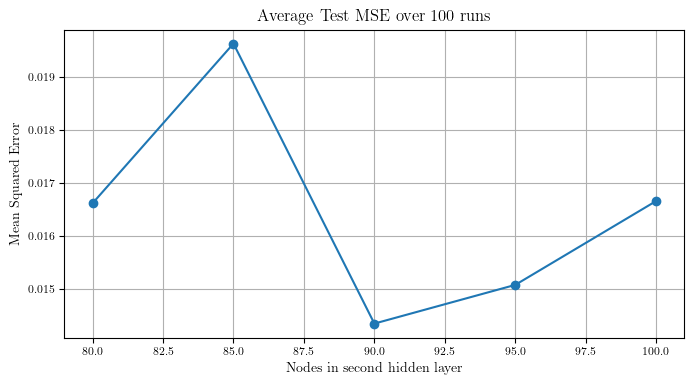

In [17]:
# Plot of the average MSE 
plt.figure(figsize=(8, 4))
plt.errorbar(num_nodes, avg_mse, fmt='o-', capsize=4)
plt.title("Average Test MSE over 100 runs")
plt.xlabel("Nodes in second hidden layer")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.show()

In [18]:
optimizer = train_network_stocastic_ADAM
activation_functions = [af.sigmoid, af.sigmoid, af.identity]
eta = 1e-1
epochs = 100
hidden1 = 40
hidden2= 90

nn = NeuralNetwork(
            x.shape[1],
            [hidden1, hidden2, 1],
            activation_functions,
            cf.mse)

optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)

# Compute MSE on the final model
predictions_test = nn.predict(x_test)
mse = cf.mse(y_test, predictions_test)
print(f"MSE after tuning hyperparameters: {mse}")

MSE after tuning hyperparameters: 0.014603148606673385


### Regularization
#### Tuning the L2 regularization strength and learning rate

In [19]:
# Using partial to predefine l2_lambda in the MSE cost function
from functools import partial

optimizer = train_network_stocastic_ADAM
activation_functions = [af.sigmoid, af.sigmoid, af.identity]
epochs = 100
hidden1 = 40
hidden2 = 90
learning_rates = np.logspace(-4, -1, num=4)
lambdas = np.logspace(-4, -1, num=4)
runs = 100  # number of experiments

# Tracking
combination_counter = Counter()
avg_mse_matrix_l2reg = np.zeros((len(lambdas), len(learning_rates)))

# Initialize a base network for this run
base_nn = NeuralNetwork(
    x.shape[1],
    [50, 100, 1],
    [af.sigmoid, af.sigmoid, af.identity],
    cf.mse)

layers_init = copy.deepcopy(base_nn.layers)

lr_labels = [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"]
lambda_labels = [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"]

for run in range(runs):
    # Printing progress
    if (run + 1) % 20 == 0 or (run + 1) == runs:
        print(f"Run {run + 1}/{runs}")

    mse_matrix = []

    # Iterating through all combinations of optimizers and learning rates, and calculate the corresponding MSE.
    for lmbda in lambdas:
        mse_row = []
        for eta in learning_rates:
            nn = NeuralNetwork(
                    x.shape[1],
                    [hidden1, hidden2, 1],
                    activation_functions,
                    cost_func=partial(cf.mse, l2_lambda=lmbda))
            # Using the same weights and biases across all models
            nn.layers = copy.deepcopy(layers_init)

            optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
            predictions = nn.predict(x_test)
            mse = cf.mse(y_test, predictions)
            mse_row.append(mse)
        
        mse_matrix.append(mse_row)

    mse_matrix = np.array(mse_matrix)

    # Accumulate MSEs across all runs
    avg_mse_matrix_l2reg += mse_matrix

    # Find the combination with the lowest MSE for this run
    update_counter(combination_counter, mse_matrix, lr_labels, lambda_labels)

# Average MSE across all runs
avg_mse_matrix_l2reg /= runs

print("\nHow often each combination achieved the lowest MSE:")
for combo, count in combination_counter.most_common():
    print(f"{combo}: {count} times")



optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)

# Compute MSE on the final model
predictions_test = nn.predict(X_test)
mse = cf.mse(y_test, predictions_test)
print(f"MSE after tuning hyperparameters: {mse}")

Run 20/100
Run 40/100
Run 60/100
Run 80/100
Run 100/100

How often each combination achieved the lowest MSE:
('$10^{-2}$', '$10^{-1}$'): 25 times
('$10^{-4}$', '$10^{-1}$'): 24 times
('$10^{-1}$', '$10^{-1}$'): 22 times
('$10^{-3}$', '$10^{-1}$'): 21 times
('$10^{-3}$', '$10^{-2}$'): 4 times
('$10^{-1}$', '$10^{-2}$'): 3 times
('$10^{-2}$', '$10^{-2}$'): 1 times
MSE after tuning hyperparameters: 0.05655119721579101


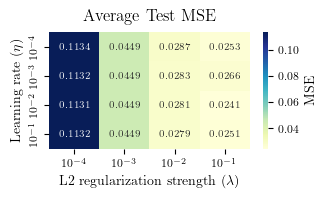

In [20]:
plt.figure()
sns.heatmap(avg_mse_matrix_l2reg, annot=True, fmt=".4f", cmap="YlGnBu",
            xticklabels=lr_labels, yticklabels=lambda_labels,
            cbar_kws={"label": "MSE"},
            annot_kws={"size": 7})

plt.title(f"Average Test MSE", pad=8)
plt.xlabel(r"L2 regularization strength ($\lambda$)")
plt.ylabel(r"Learning rate ($\eta$)")
plt.tight_layout()
plt.show()

#### Tuning the L1 regularization strength and learning rate

In [21]:
optimizer = train_network_stocastic_ADAM
activation_functions = [af.sigmoid, af.sigmoid, af.identity]
epochs = 100
hidden1 =40
hidden2= 90
learning_rates = np.logspace(-4, -1, num=4)
lambdas = np.logspace(-4, -1, num=4)
runs = 100  # number of experiments

# Tracking
combination_counter = Counter()
avg_mse_matrix_l1reg = np.zeros((len(lambdas), len(learning_rates)))

#labels
lr_labels = [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"]
lambda_labels = [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"]

# Initialize a base network for this run
base_nn = NeuralNetwork(
    x.shape[1],
    [50, 100, 1],
    [af.sigmoid, af.sigmoid, af.identity],
    cf.mse)

layers_init = copy.deepcopy(base_nn.layers)

for run in range(runs):
    # Printing progress
    if (run + 1) % 20 == 0 or (run + 1) == runs:
        print(f"Run {run + 1}/{runs}")

    mse_matrix = []

    # Iterating through all combinations of optimizers and learning rates, and calculate the corresponding MSE.
    for lmbda in lambdas:
        mse_row = []
        for eta in learning_rates:
            # Create a new neural network for this combination
            nn = NeuralNetwork(
                    x.shape[1],
                    [hidden1, hidden2, 1],
                    activation_functions,
                    cost_func=partial(cf.mse, l1_lambda=lmbda))
            
            # Using the same initial weights and biases across all models
            nn.layers = copy.deepcopy(layers_init)

            optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
            predictions = nn.predict(x_test)
            mse = cf.mse(y_test, predictions)
            mse_row.append(mse)

        mse_matrix.append(mse_row)

    mse_matrix = np.array(mse_matrix)

    # Accumulate MSEs across all runs
    avg_mse_matrix_l1reg += mse_matrix

    # Find the combination with the lowest MSE for this run
    update_counter(combination_counter, mse_matrix, lr_labels, lambda_labels)

# Average MSE across all runs
avg_mse_matrix_l1reg /= runs

print("\nHow often each combination achieved the lowest MSE:")
for combo, count in combination_counter.most_common():
    print(f"{combo}: {count} times")

Run 20/100
Run 40/100
Run 60/100
Run 80/100
Run 100/100

How often each combination achieved the lowest MSE:
('$10^{-3}$', '$10^{-1}$'): 29 times
('$10^{-1}$', '$10^{-1}$'): 24 times
('$10^{-4}$', '$10^{-1}$'): 24 times
('$10^{-2}$', '$10^{-1}$'): 22 times
('$10^{-2}$', '$10^{-2}$'): 1 times


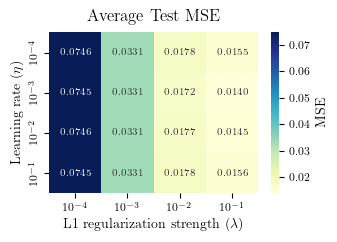

In [22]:
# Heatmap
plt.figure()
sns.heatmap(avg_mse_matrix_l1reg, annot=True, fmt=".4f", cmap="YlGnBu",
            xticklabels=lr_labels, yticklabels=lambda_labels,
            cbar_kws={"label": "MSE"},
            annot_kws={"size": 7})

plt.title(f"Average Test MSE", pad=8)
plt.xlabel(r"L1 regularization strength ($\lambda$)")
plt.ylabel(r"Learning rate ($\eta$)")
plt.show()

### Pytorch implementation

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert to torch tensors
X_train_t = torch.tensor(x_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(x_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)


In [24]:

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2):
        super(FFNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.Sigmoid(),             
            nn.Linear(hidden1, hidden2),
            nn.Sigmoid(),
            nn.Linear(hidden2, 1))

    def forward(self, x):
        return self.layers(x)


eta_ols = 1e-1
eta_l1 = 1e-1
eta_l2 = 1e-1
epochs = 100
hidden1 = 40
hidden2 = 90
l1_reg = 1e-1
l2_reg = 1e-2


# Cost function
mse = nn.MSELoss()

# Model initialization
model_ols = FFNN(1, hidden1, hidden2)
model_l1 = FFNN(1, hidden1, hidden2)
model_l2 = FFNN(1, hidden1, hidden2)

#Optimizer
optimizer_ols = optim.Adam(model_ols.parameters(), lr=eta_ols)
optimizer_l1 = optim.Adam(model_l1.parameters(), lr=eta_l1)
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=eta_l2, weight_decay=l2_reg)  

# Training the models
for epoch in range(epochs):
    model_ols.train()
    optimizer_ols.zero_grad()
    y_pred = model_ols(X_train_t)
    loss = mse(y_pred, y_train_t)
    loss.backward()
    optimizer_ols.step()

for epoch in range(epochs):
    model_l1.train()
    optimizer_l1.zero_grad()
    y_pred = model_l1(X_train_t)
    loss = mse(y_pred, y_train_t)

    # Add L1 penalty manually as its not differentiable at 0
    l1_penalty = 0
    for param in model_l1.parameters():
        l1_penalty += torch.sum(torch.abs(param))
    loss += l1_reg * l1_penalty

    loss.backward()
    optimizer_l1.step()

for epoch in range(epochs):
    model_l2.train()
    optimizer_l2.zero_grad()
    y_pred = model_l2(X_train_t)
    loss = mse(y_pred, y_train_t)
    loss.backward()
    optimizer_l2.step()


# Evaluating the models
model_ols.eval()
with torch.no_grad():
    y_pred_test = model_ols(X_test_t)
    mse_test = mse(y_pred_test, y_test_t).item()
    print(f"Test MSE with no regularization: {mse_test:.4f}")

model_l2.eval()
with torch.no_grad():
    y_pred_test = model_l2(X_test_t)
    mse_test = mse(y_pred_test, y_test_t).item()
    print(f"Test MSE with L2 regularization: {mse_test:.4f}")

model_l1.eval()
with torch.no_grad():
    y_pred_test = model_l1(X_test_t)
    mse_test = mse(y_pred_test, y_test_t).item()
    print(f"Test MSE with L1 regularization: {mse_test:.4f}")




Test MSE with no regularization: 0.1129
Test MSE with L2 regularization: 1.1729
Test MSE with L1 regularization: 0.1245
